# ASSIGNMENT 4 - NIKO PATERNITI BARBINO 638257

**Perform image segmentation on all images in the dataset, using the normalized cut algorithm running on the top of superpixels rather than on raw pixels. For each image compute an accuracy metric (which one it is up to you to decide) measuring the overlap between the image segments identified by NCUT and the ground truth semantic segmentation. Provide a table summarizing the average accuracy on all images (for the different visual classes), plus present 2 examples of images that are well-segmented (according to the above defined metric)**.

Hint: in Python, you have an NCut implementation in the scikit-image library; in Matlab, you can use the original NCut implementation here. Superpixels are implemented both in Matlab as well as in OpenCV. Feel free to pickup the implementation you liked most (and motivate the choice).

In [1]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing Libraries**

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.future import graph
from skimage.metrics import structural_similarity
from skimage import data, segmentation, color
import networkx

**We used SEEDS (Superpixels Extracted via Energy-Driven Sampling):**

The algorithm uses an efficient hill-climbing algorithm to optimize the superpixels' energy function that is based on color histograms and a boundary term, which is optional. The energy function encourages superpixels to be of the same color, and if the boundary term is activated, the superpixels have smooth boundaries and are of similar shape. In practice it starts from a regular grid of superpixels and moves the pixels or blocks of pixels at the boundaries to refine the solution.

In [3]:
def get_superpixels(image, iter = 10, prior = 5, n_superpixels = 350, n_levels = 20, n_bins = 20,
                    print_intermediate=True, intermediate_name='result.jpg'):
    
    conv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    height, width, channels = conv_img.shape

    # We used all white images to show the computed superpixels superimposed on the original image
    mask_img = np.zeros((height, width, 3), np.uint8)
    mask_img[:] = (255, 255, 255)

    # SEEDS creation and iterations
    seeds = cv2.ximgproc.createSuperpixelSEEDS(width, height, channels, n_superpixels, n_levels, prior, n_bins)
    seeds.iterate(conv_img, iter)

    # Superpixels
    labels = seeds.getLabels()
    mask = seeds.getLabelContourMask(False)

    if (print_intermediate):  
        mask_inv = cv2.bitwise_not(mask)
        result_bg = cv2.bitwise_and(image, image, mask = mask_inv)
        result_fg = cv2.bitwise_and(mask_img, mask_img, mask = mask)
        result = cv2.add(result_bg, result_fg)
        cv2.imwrite(intermediate_name, result)

    return labels

**We used the NCut implementation in the scikit-image library**

In [4]:
def ncut(img, labels):
    rag = graph.rag_mean_color(img, labels, mode='similarity', sigma=512.0)
    new_labels = graph.ncut(labels, rag)
    return new_labels     
def save_segmentation(img, labels, name='ncut.jpg'):
    color_list = [(0,0,0), (128,0,0), (0,128,0), (128,128,0), (0,0,128), (128,0,128), (0,128,128), (128,128,128), (64,0,0), (192,0,0), (64,128,0), (192,128,0), (64,0,128), (192,0,128)]
    out = color.label2rgb(labels, img, kind='overlay', bg_label=0, colors=color_list, alpha=1)
    cv2.imwrite(name, out)

In [5]:
#Making sure im in the correct working directory

os.chdir("/content/MSRC_ObjCategImageDatabase_v1")
os.getcwd()

'/content/MSRC_ObjCategImageDatabase_v1'

In [6]:
PATH="/content/MSRC_ObjCategImageDatabase_v1"

In [7]:
#I downgraded networkx due to deprecated functions that generated inconsistencies using the libraries
#Uncomment the following lines if needed

#!pip uninstall networkx
#!pip install networkx==2.7

# SEGMENTATION

Here we will perform the image segmentation:

What we will achieve are colours coded with the dataset's image's colours 


In [8]:
for image in os.listdir(PATH):
    if (image[-3:] == "bmp"): 
      if (image[-6:] != "GT.bmp"): 
          if not os.path.exists(PATH+"/results/img_" + image[0] + "_segm"):
            os.makedirs("results/img_" + image[0] + "_segm")
          if not os.path.exists(PATH+"/results/img_" + image[0] + "_interm"):
            os.makedirs("results/img_" + image[0] + "_interm")
          print("\rSegmenting " + image[:-4], end=" ")
          img = cv2.imread("./" + image)
          labels = get_superpixels(img, intermediate_name="results/img_" + image[0] + "_interm/" + image)
          new_labels = ncut(img, labels)
          save_segmentation(img, new_labels, name = "results/img_" + image[0] + "_segm/" + image)
print("Images Segmentation finished.")

Segmenting 4_15_s Images Segmentation finished.


# COMPARISONS


**We compute the differences between the segmented images and the ground truths using the structural similarity metric
(scikit-image library).**

In [9]:
def compare(image1, image2):
    return structural_similarity(image1, image2, channel_axis=2, gradient=False, full=False, multichannel=True)

In [10]:
print("Comparing...")

result = {}

for dir in os.listdir("results"):

    if (dir[-4:] == "segm"):
        for image in os.listdir(path="results/" + dir):
            print("\rComparing " + image[:-4], end=" ")
            image1 = cv2.imread("results/" + dir + "/" + image)
            image2 = cv2.imread("./" + image[:-4] + "_GT.bmp")
            metric_value = compare(image1, image2)
            result[image[:-4]] = metric_value

result = {k:v for k, v in sorted(result.items(), key = lambda item : item[1], reverse=True)}

per_class = [0, 0, 0, 0, 0, 0, 0, 0]

for k in result:
    per_class[int(k[0]) - 1] += result[k]

print("Done.")

Comparing...
Comparing 6_13_s 

<ipython-input-9-7ce24043f2d8>:2: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return structural_similarity(image1, image2, channel_axis=2, gradient=False, full=False, multichannel=True)


Comparing 2_2_s Done.


In [11]:
#Function to save the Structural Similarity of the images
def save_SSIM(image1, image2, filename):
    img = structural_similarity(image1, image2, channel_axis=2, gradient=False, full=True, multichannel=True)[1]
    img = (img*255).astype("uint8")
    cv2.imwrite(filename, img)

In [12]:
print("Mean metric...")
for i in range(8):
    per_class[i] /= 30
    print("\tClass " + str(i+1) +":"+"\t" + str(per_class[i]))

print("----------------------------------------")

print("BEST 5 EVALUATED IMAGES:")
if not os.path.exists("results/best"): 
  os.mkdir("results/best")

i = 0

for k in result:
    print("\t" + k + "\t" + str(result[k]))
    image1 = cv2.imread("results/img_" + k[0] + "_segm/" + k + ".bmp")
    image2 = cv2.imread("./" + k + "_GT.bmp")
    img = save_SSIM(image1, image2, "results/best/" + k + "_structural_sim.bmp")
    i += 1
    if i == 5: break

result = {k:v for k, v in sorted(result.items(), key = lambda item : item[1], reverse=False)}
print("----------------------------------------")
print("WORST 5 EVALUATED IMAGES:")
if not os.path.exists("results/worst"):
   os.mkdir("results/worst")

i = 0

for k in result:
    print("\t" + k + "\t" + str(result[k]))
    image1 = cv2.imread("results/img_" + k[0] + "_segm/" + k + ".bmp")
    image2 = cv2.imread("./" + k + "_GT.bmp")
    img = save_SSIM(image1, image2, "results/worst/" + k + "_structural_sim.bmp")
    i += 1
    if i == 5: break


Mean metric...
	Class 1:	0.5943731070135684
	Class 2:	0.25506108561944646
	Class 3:	0.3799320138949292
	Class 4:	0.3091405954255016
	Class 5:	0.5805327561429794
	Class 6:	0.5940717637792916
	Class 7:	0.46480816502890215
	Class 8:	0.48640344238269806
----------------------------------------
BEST 5 EVALUATED IMAGES:
	6_10_s	0.8240932019390886
	6_29_s	0.8190302486609783
	5_20_s	0.8036059604405522
	6_21_s	0.7938963457036515
	5_7_s	0.7824433520254935
----------------------------------------
WORST 5 EVALUATED IMAGES:
	3_30_s	0.06682478308396314
	2_28_s	0.07842887883029322


<ipython-input-11-46e910ff8785>:3: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = structural_similarity(image1, image2, channel_axis=2, gradient=False, full=True, multichannel=True)[1]


	2_24_s	0.08703223624301142
	2_29_s	0.09080767400254619
	2_13_s	0.10326082843157873


# FINAL CONSIDERATIONS

The resulting table shows us that the best evaluated images are:

-6_10_s	 SIMILARITY:  0.8240932019390886

-6_29_s	 SIMILARITY:  0.8190302486609783

And the worst evaluated images are:

3_30_s	 SIMILARITY;  0.06682478308396314

2_28_s	 SIMILARITY;  0.07842887883029322



We can see that the algorithm does not correcty learn correctly the color to be assigned to the detected areas, so we risk to evaluate images uncorrectly even if we correctly identify the image's shape.
This may occur because of the choice of a too dark or too bright colour

We might improve the algorithm trying to detect the areas based on the mean color of the images instead of their shape

I found solving this problem very interesting but also very challenging due to the fact that i had never previously worked on a similar problem.
It took me a while to understand how to correctly use the libraries in relation to this problem and i also looked at different videos and papers to find a way to correctly approach the problem with code.


In [13]:
from matplotlib import pyplot as plt
from skimage import io


# BEST 2 EVALUATED IMAGES

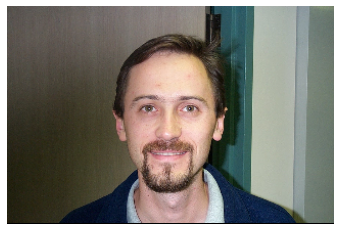

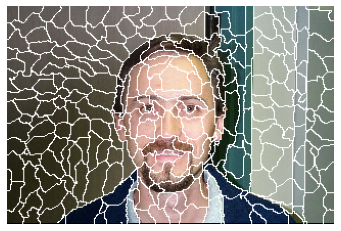

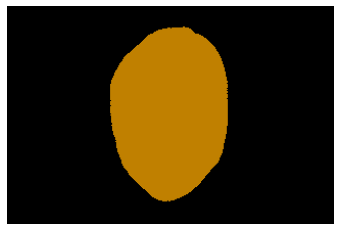

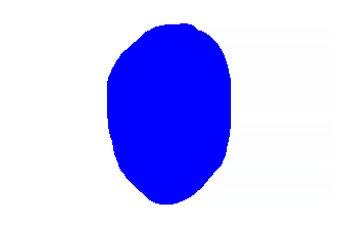

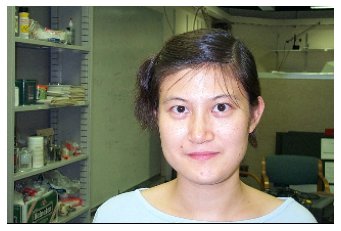

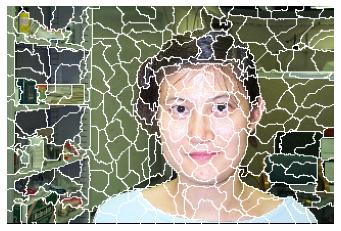

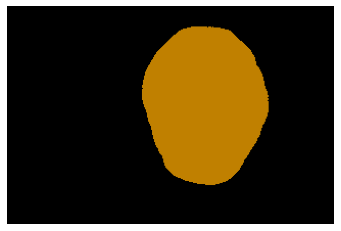

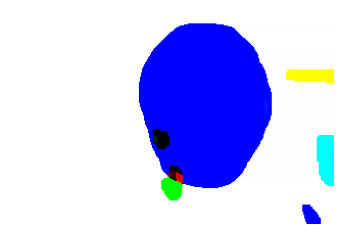

In [23]:
image = io.imread("/content/MSRC_ObjCategImageDatabase_v1/6_10_s.bmp")
plt.imshow(image)
plt.axis("off")
plt.show()

image6 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/results/img_6_interm/6_10_s.bmp")
plt.imshow(image6)
plt.axis("off")
plt.show()

image1 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/6_10_s_GT.bmp")
plt.imshow(image1)
plt.axis("off")
plt.show()

image2 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/results/best/6_10_s_structural_sim.bmp")
plt.imshow(image2)
plt.axis("off")
plt.show()

image3 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/6_29_s.bmp")
plt.imshow(image3)
plt.axis("off")
plt.show()

image7 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/results/img_6_interm/6_29_s.bmp")
plt.imshow(image7)
plt.axis("off")
plt.show()

image4 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/6_29_s_GT.bmp")
plt.imshow(image4)
plt.axis("off")
plt.show()

image5 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/results/best/6_29_s_structural_sim.bmp")
plt.imshow(image5)
plt.axis("off")
plt.show()


# WORST 2 EVALUATED IMAGES

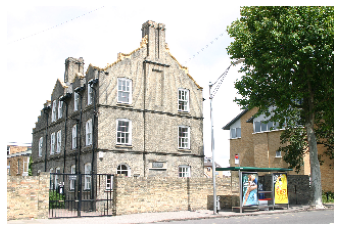

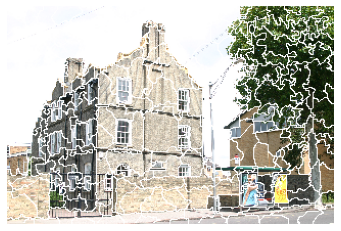

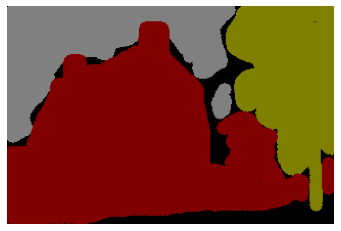

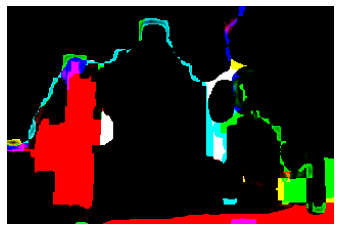

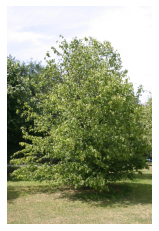

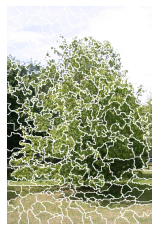

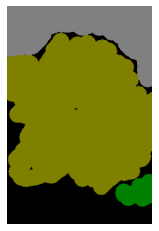

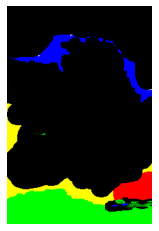

In [25]:
image8 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/3_30_s.bmp")
plt.imshow(image8)
plt.axis("off")
plt.show()

image9 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/results/img_3_interm/3_30_s.bmp")
plt.imshow(image9)
plt.axis("off")
plt.show()

image10 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/3_30_s_GT.bmp")
plt.imshow(image10)
plt.axis("off")
plt.show()

image11 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/results/worst/3_30_s_structural_sim.bmp")
plt.imshow(image11)
plt.axis("off")
plt.show()

image12 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/2_28_s.bmp")
plt.imshow(image12)
plt.axis("off")
plt.show()

image13 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/results/img_2_interm/2_28_s.bmp")
plt.imshow(image13)
plt.axis("off")
plt.show()

image14 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/2_28_s_GT.bmp")
plt.imshow(image14)
plt.axis("off")
plt.show()

image15 = io.imread("/content/MSRC_ObjCategImageDatabase_v1/results/worst/2_28_s_structural_sim.bmp")
plt.imshow(image15)
plt.axis("off")
plt.show()